# Fine-tunig modello LayoutLM con Trasformers Hugging Face

FUNSD --> Da analizzare la sturttura online. Vedere se le etichette sono le stesse.
- qui le etichette sono queste: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
- in quello scaricato sono diverse,
- ad ogni modo, non posso addestrare il modello con queste etichette e su dei form e poi fare il fine tuning sui miei estratti conto?? (direi di no, o che non sia un granchè)

In [ ]:
# installo pytesseract, transformers, datasets, seqeval e tensorboard
!pip install pytesseract transformers datasets seqeval tensorboard

# Installazione di git-lfs per gestire i modelli e i log su Hugging Face Hub (non so se il comando sia corretto, originale: !sudo apt-get install git-lfs --yes)
!pip install git-lfs

Come "fine-tunare" LayoutLM per estrarre informazioni dai documenti e visualizzarli. Con solo 149 esempi di training, il modello ha raggiunto un punteggio F1 di 0.86.

0. Librerie

In [3]:
import numpy as np
import torch 

# Installazione: conda install anaconda::ipywidgets
from huggingface_hub import notebook_login, HfFolder 
# notebook_login: per fare il login su Hugging Face Hub (accedere a modelli e dataset) 
# HfFolder: per gestire la cartella locale di Hugging Face (memorizzazione token e configurazione)

from datasets import load_dataset, Features, Sequence, ClassLabel, Value, Array2D
# load_dataset: per caricare un dataset
# Features: per definire le features di un dataset
# Sequence: per definire una sequenza di elementi
# ClassLabel: per definire una classe di etichette
# Value: per definire un valore
# Array2D: per definire un array bidimensionale

# PIL: Python Imaging Library, per manipolare immaginI
from PIL import Image, ImageDraw, ImageFont

# Libreria transformers di Hugging Face:
# LayoutLMv2Processor: per processare i dati in input del modello LayoutLMv2
# LayoutLMForTokenClassification: per classificare i token di un testo
# TrainingArguments: per definire gli argomenti di addestramento
# Trainer: per addestrare un modello
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, TrainingArguments, Trainer

from functools import partial
# partial: per creare funzioni parziali (funzioni con alcuni argomenti predefiniti) -https://docs.python.org/3/library/functools.html

import evaluate # pip install evaluate
# per calcoalre metriche di valutazione su moodelli di ML


1. Log-in Hugging face

In [5]:
# Per fare  il login su Hugging Face per salvare i modelli e i risultati.
notebook_login() # va creato il token --> dare come permesso "write"

3. Caricamento dataset

In [7]:
# Da HuggingFace: https://huggingface.co/datasets/nielsr/funsd
dataset_id ="nielsr/funsd" 

# Salvo il dataset in una variabile
dataset = load_dataset(dataset_id, trust_remote_code=True) # trust_remote_code=True, permette di esequire il codice remoto

# Stampo diemnsione del dataset di train e test
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

# Se volessimo  replicare il dataset con soli estrattti conto tra immagini(ciascuna con annotaizone)--> necessarie 200 crica 

Train dataset size: 149
Test dataset size: 50


In [19]:
print(dataset) # stampo struttura del dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 50
    })
})


In [23]:
print(dataset['train'][0]) # stampo il primo elemento del dataset di train

{'id': '0', 'words': ['R&D', ':', 'Suggestion:', 'Date:', 'Licensee', 'Yes', 'No', '597005708', 'R&D', 'QUALITY', 'IMPROVEMENT', 'SUGGESTION/', 'SOLUTION', 'FORM', 'Name', '/', 'Phone', 'Ext.', ':', 'M.', 'Hamann', 'P.', 'Harper,', 'P.', 'Martinez', '9/', '3/', '92', 'R&D', 'Group:', 'J.', 'S.', 'Wigand', 'Supervisor', '/', 'Manager', 'Discontinue', 'coal', 'retention', 'analyses', 'on', 'licensee', 'submitted', 'product', 'samples', '(Note', ':', 'Coal', 'Retention', 'testing', 'is', 'not', 'performed', 'by', 'most', 'licensees.', 'Other', 'B&W', 'physical', 'measurements', 'as', 'ends', 'stability', 'and', 'inspection', 'for', 'soft', 'spots', 'in', 'ciparettes', 'are', 'thought', 'to', 'be', 'sufficient', 'measures', 'to', 'assure', 'cigarette', 'physical', 'integrity.', 'The', 'proposed', 'action', 'will', 'increase', 'laboratory', 'productivity', '.', ')', 'Suggested', 'Solutions', '(s)', ':', 'Delete', 'coal', 'retention', 'from', 'the', 'list', 'of', 'standard', 'analyses', 'per

4. Esempio di un campione

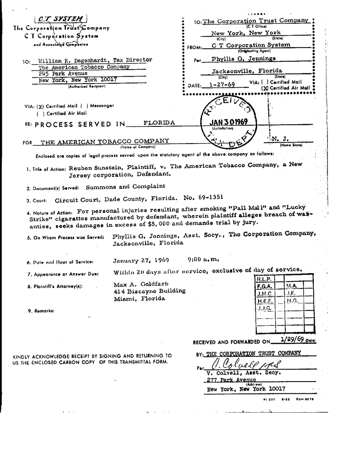

In [24]:
image = Image.open(dataset['train'][34]['image_path'])
image = image.convert("RGB")
image.resize((350,450))

5. Creazione etichette del dataset 

In [32]:
# Le etichette vengono estratte e mappate in due dizionari: 'id2label' e 'label2id'
labels = dataset['train'].features['ner_tags'].feature.names # estraggo le etichette del tassk NER (Named Entity Recognition)
    # feature.names: restituisce i nomi delle etichette
    # features: restituisce le features del dataset
    # dataset['train']: restituisce il dataset di train

print(f"Available labels: {labels}")

# Creo due dizionari per mappare le etichette con gli id e viceversa
id2label = {v: k for v, k in enumerate(labels)} 
label2id = {k: v for v, k in enumerate(labels)}
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
id2label: {0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}
label2id: {'O': 0, 'B-HEADER': 1, 'I-HEADER': 2, 'B-QUESTION': 3, 'I-QUESTION': 4, 'B-ANSWER': 5, 'I-ANSWER': 6}


6. Caricamento e pre-processamento modello

In [10]:
# Modello uutilizzato per il pre-preprocessamento: https://huggingface.co/microsoft/layoutlmv2-base-uncased
processor_id="microsoft/layoutlmv2-base-uncased"
# LayoutLMv2 processor combina LayoutLMv2 feature extractor e  LayoutLMv2 tokenizer insieme.
# OCR false, perchè già fatto in precedenza
processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

In [11]:
# Feature custom per il modello
# class Features: per definire le features di un dataset
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")), # sequenza di valori interi (id dei token dopo la tokenizzazione)
        "attention_mask": Sequence(Value(dtype="int64")), # sequenza di valori interi (mask per i token, 1 se token, 0 se padding(ignorato))
        "token_type_ids": Sequence(Value(dtype="int64")), # sequenza di valori interi (per distinguere tra due frasi)
        "bbox": Array2D(dtype="int64", shape=(512, 4)), # array bidimensionale di valori interi (coordinate dei bounding box)
        "labels": Sequence(ClassLabel(names=labels)), # sequenza di etichette (NER tags)
    }
)

# funzione per processare un campione del dataset
def process(sample, processor=None): 
    # Utilizza il processore LayoutLMv2 per tokenizzare le parole, 
    # aggiungere padding fino alla lunghezza massima (max_length) 
    # e troncate se necessario
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"], # parole nel campione
        boxes=sample["bboxes"], # bounding boxes nel campione
        word_labels=sample["ner_tags"], # etichette NER nel campione
        padding="max_length", # padding fino alla lunghezza massima
        truncation=True, # troncamento 
    )
    del encoding["image"] # rimuovo l'immagine dall'encoding 

    return encoding 

# map: applica una funzione a tutti gli elementi di un dataset 
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"], # rimuovo colonne originale 
    features=features,
).with_format("torch") # converto dataset in formato PyTorch (per addestramento)

print(proc_dataset["train"].features.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


7. Fine-tuning e valutazione

In [6]:
model_id = "microsoft/layoutlm-base-uncased"

# Carico il modello pre-addestrato con il corretto numero di labels e mappature
model = LayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

NameError: name 'labels' is not defined

8. Metriche di valutazione

In [13]:
metric = evaluate.load("seqeval") # carico la metrica Seqeval per valutazione dell'etichettatura delle sequenze (NER)

ner_labels = list(model.config.id2label.values()) # etichette NER del modello (converto i valori del dizionario in una lista)

# Funzione per calcolare le metriche
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2) # indice dell'elementro con il valore massimo lungo l'asse 2

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels): # zip: combina due liste in un'unica lista di tuple
        for predicted_idx, label_idx in zip(prediction, label): # itera sugli indici predetti e reali
            if label_idx == -100: # ignora i token di padding (label_idx = -100)
                continue
            all_predictions.append(ner_labels[predicted_idx]) # aggiungi l'etichetta predetta
            all_labels.append(ner_labels[label_idx]) # aggiungi l'etichetta reale
    return metric.compute(predictions=[all_predictions], references=[all_labels]) # calcola le metriche, fornendo le due liste (etiche predette e reali)


In [37]:
print(list(model.config.id2label.values()))

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


9. Argomenti di training

In [4]:
# repository per salvataggio modello (in locale)
repository_id = "layoutlm-funsd"

# Tutti gli argomenti di addestramento
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=15,
    per_device_train_batch_size=16, # batch size per training
    per_device_eval_batch_size=8, # batch size per evaluation
    fp16=True, # abilita addestramento a precisione mista (+ veloce - GPU)
    learning_rate=3e-5,
    # salvataggio e logging
    logging_dir=f"{repository_id}/logs", # directory in cui salvare i log
    logging_strategy="epoch", # regsitro i log alla fine di ogni epoca
    evaluation_strategy="epoch", # valutazione del modello alla fine di ogni epoca
    save_strategy="epoch", # salva il modello alla fine di ogni epoca
    save_total_limit=2, # numero massimo di modelli(checkpoint) da salvare
    load_best_model_at_end=True, # carica il miglior modello alla fine dell'addestramento
    metric_for_best_model="overall_f1", # metrica per selezionare il miglior modello
    # Parametri per il Push su Hugging Face
    report_to="tensorboard", # invio i log a TensorBoard
    push_to_hub=True, # salva il modello su Hugging Face
    hub_strategy="every_save", # ad ogni salvataggo, salva il modello su Hugging Face
    hub_model_id=repository_id, # ID del modello su Hugging Face
    hub_token=HfFolder.get_token(), # token per accedere a Hugging Face
) 


c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\transformers\training_args.py:1504: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


10. Addestramento

In [5]:
# Creazione istanza del Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)
# Addestramento del modello
trainer.train()

NameError: name 'model' is not defined

11. Inferenza

In [ ]:
# Cambiamo il comportamento del processore LayoutLMv2:
# applichiamo l'OCR durante il processamento 
processor.feature_extractor.apply_ocr = True

# Salvo il processore e il modello
processor.save_pretrained(repository_id)
trainer.create_model_card() # crea la card del modello (descrizione, attribuzioni, ecc.)
trainer.push_to_hub() # salva il modello addestrato su Hugging Face

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/451M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

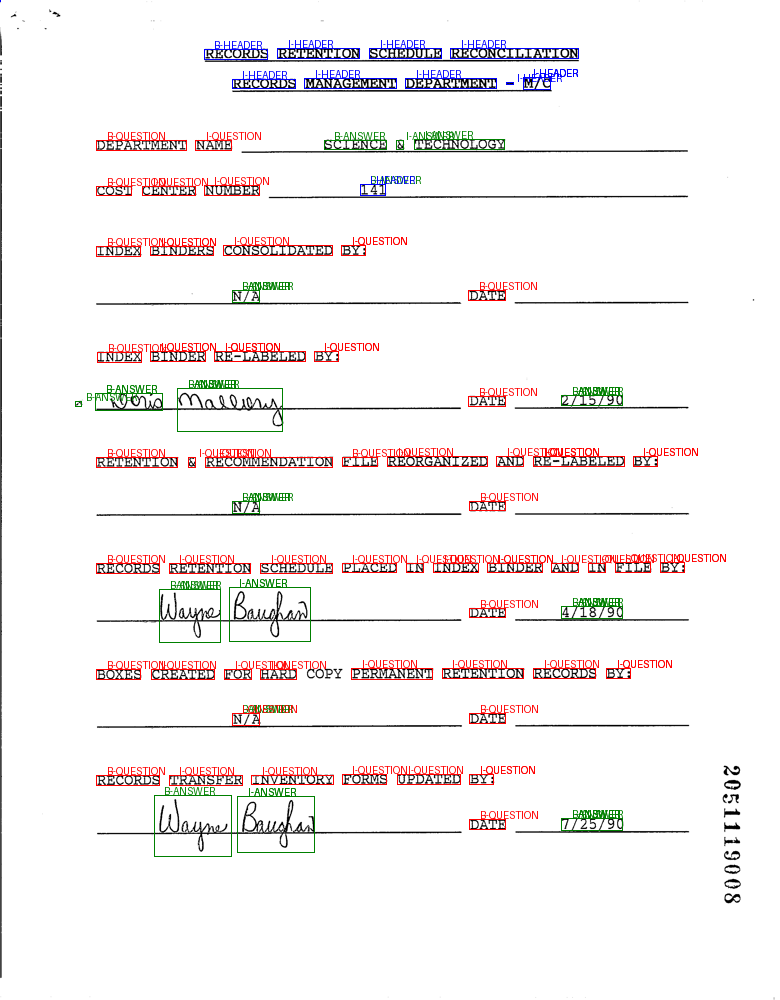

In [39]:
# Carico il modello addestrato addestrato su FUNSD da Hugging Face
# Carico il processore addestrato su FUNSD da Hugging Face
model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd") # qui poi carico il mio MODELLO 
processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd")


# Converte le coordinate delle bounding box da coordinate 
# normalizzate a coordinate non normalizzate (basate sulla dimensione dell'immagine)
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

# Dizionario per mappare le etichette ai colori
label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}

# Disegna i bounding box sull'immagine
# input: immagine, bounding box, etichette predette
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # Disegno eticcette e bounding box sull'immagine
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# Esegui l'inferenza su un'immagine
def run_inference(path, model=model, processor=processor, output_image=True):

    image = Image.open(path).convert("RGB")
    # processa l'immagine, restituisce un tensore 
    encoding = processor(image, return_tensors="pt")
    del encoding["image"]
    # esege inferenza del modello
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # converte output in etichette
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels


run_inference(dataset["test"][34]["image_path"])